# 1. Import

In [34]:
import os
import glob
import json
import re
import string

from datasets import Dataset
from tqdm.auto import tqdm
from transformers.pipelines.pt_utils import KeyDataset
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax
import tensorflow as tf
import transformers as tr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pretty_confusion_matrix import pp_matrix

print('Tensorflow version:', tf.__version__)
print('Transformers version:', tr.__version__)

Tensorflow version: 2.8.0
Transformers version: 4.16.2


# 2. Process raw files

## Functions

In [6]:
def get_filenames(directory_path: str, file_extension: str) -> list:
    """
    Takes in a filepath and file extension type and returns a list of file names in the same directory.

    Args:
        directory_path (str): The base path to folder directory containing all data files
        file_extension (str): The file extension type, e.g. (txt, json, csv).

    Returns:
        list: List of filenames with given extension type.
    """
    file_list = []
    for file in glob.glob(f"{directory_path}/*.{file_extension}"):
        # file_list.append(file)
        file_list.append(os.path.relpath(file, os.getcwd()))
    return file_list

In [7]:
def fb_filenames_to_df(filenames: list) -> pd.DataFrame:
    """
    Takes in a list of Facebook filenames and converts all text data into a dataframe.

    Args:
        filenames (list): List of Facebook filenames.

    Returns:
        pd.DataFrame: Dataframe containing all texts.
    """

    df = pd.DataFrame()

    for filename in filenames:
        temp_df = pd.read_csv(filename, sep=";", low_memory=False)
        df = pd.concat([df, temp_df["message"].to_frame("text")], ignore_index=True)

    df = df.dropna().drop_duplicates(ignore_index=True).reset_index(drop=True)

    return df

In [8]:
def reddit_filenames_to_df(filenames: list) -> pd.DataFrame:
    """
    Takes in a list of Reddit filenames and converts all text data into a dataframe.

    Args:
        filenames (list): List of Reddit filenames.

    Returns:
        pd.DataFrame: Dataframe containing all texts.
    """

    df = pd.DataFrame()

    for filename in filenames:
        file = open(filename)
        data = json.load(file)

        for post_id in data:
            if comments := data[post_id]["comments"]:

                for cid in comments:
                    temp_dict = {
                        "text": comments[cid].get("body"),
                    }
                    df = df.append(temp_dict, ignore_index=True)

    df = df.dropna().drop_duplicates(ignore_index=True).reset_index(drop=True)

    return df

In [9]:
def twitter_filenames_to_df(filenames: list) -> pd.DataFrame:
    """
    Takes in a list of Twitter filenames and converts all text data into a dataframe.

    Args:
        filenames (list): List of Twitter filenames.

    Returns:
        pd.DataFrame: Dataframe containing all texts.
    """
    df = pd.DataFrame()

    for filename in filenames:
        for tweet in open(filename, 'r'):
            tweet_data = json.loads(tweet)
            if tweet_data['language'] == 'en':
                df = df.append({'text':tweet_data['tweet']}, ignore_index=True)

    df = df.dropna().drop_duplicates(ignore_index=True).reset_index(drop=True)

    return df

## Process Facebook

### Main csv

In [95]:
filenames = get_filenames(
    directory_path = "/home/joshua/NLP/data/facebook_raw", 
    file_extension = "csv"
)
print(filenames)

['data/facebook_raw/stomp.csv', 'data/facebook_raw/rice media.csv', 'data/facebook_raw/mustsharenews.csv', 'data/facebook_raw/all singapore stuff.csv', 'data/facebook_raw/today.csv', 'data/facebook_raw/straits times.csv', 'data/facebook_raw/yahoo singapore.csv', 'data/facebook_raw/wakeup singapore.csv', 'data/facebook_raw/straits times comments.csv', 'data/facebook_raw/cna.csv', 'data/facebook_raw/cna insider.csv', 'data/facebook_raw/singapore matters.csv', 'data/facebook_raw/mothership.csv']


In [96]:
df = fb_filenames_to_df(filenames)
df

,text
0,"Before the days of Internet dating, there was ..."
1,Who loves love stories too? 🙋‍♀️🙋‍♂️
2,Wahhhh Bari not bad u famous liao
3,god bless both of you. inspirational story
4,"Man, allegedly high on drugs, tackled by polic..."
...,...
1988111,Save water or skimmed on ingredients .
1988112,Well Done Students
1988113,Congratulations 👏 👍🥳
1988114,My ice Milo always 90% ice


In [21]:
df.to_csv("./data/processed_data/facebook.csv", encoding="utf-8-sig")

### Comments to label

In [78]:
df = pd.read_csv("./data/processed_data/facebook.csv", index_col=0)
df = df[df.text.apply(lambda x: len(x) > 250 and len(x) < 300)]
df = df.reset_index(drop=True)
df

,text
0,The last time i read two cases the man was sho...
1,what a bloody stupid woman! She's at fault n ...
2,Do not be judgemental. There are lots of good ...
3,Tot this only happened in the early 80s to 90s...
4,your parents work so hard whole day so that t...
...,...
45402,Talking about ice for three different types of...
45403,Maybe i should also do another project to incr...
45404,Try arguing with aunties and uncles at drinks ...
45405,"I have doubt about the idea, i hv thought abou..."


In [80]:
df = df.sample(n=150)
df = df.reset_index(drop=True)
df

,text
0,This is scary. Actually at Little India mrt st...
1,"When a government is legally elected, they wil..."
2,Discretionary turn again. All heavy traffic ju...
3,I know of quite a few very rich millionaire bu...
4,Agenda 21 population control from US and EU wi...
...,...
145,"Lol... Last year this time, Creative shared cl..."
146,When public complaint n make viral the ministr...
147,Lucky for the boys. Phone were working well. G...
148,Saying this. And then you allow infected vac...


In [81]:
df.to_csv("./data/processed_data/facebook_test.csv", encoding="utf-8-sig")

## Process Reddit

In [11]:
filenames = get_filenames(
    directory_path = "/home/joshua/NLP/data/reddit_raw",
    file_extension= "json"
)
print(filenames)

['data/reddit_raw/2022-01-28.json']


In [12]:
df = reddit_filenames_to_df(filenames)
df

,text
0,"by this stage, it isn’t Covid-19 that is to bl..."
1,This article brought to u by Captain Obvious >.<
2,"Again, time to open up. Open up economy entire..."
3,"Hey look, more experts"
4,"> # Covid-19 pandemic, border restrictions may..."
...,...
1708,"Oh god, I remember terrible the brain fog and ..."
1709,It's Lepax! (escitalopram) Costs like 50bux pe...
1710,Yup i know its usually supposed to work after ...
1711,My friend who used to be on effexor said once ...


In [25]:
df.to_csv("./data/processed_data/reddit.csv", encoding="utf-8-sig")

### Reddit file to label

In [21]:
df = pd.read_csv("./data/processed_data/reddit.csv", index_col=0, lineterminator='\n')
df = df[df.text.apply(lambda x: len(x) > 200 and len(x) < 400)]
df = df.sample(n=100)
df = df.reset_index(drop=True)
df

,text
0,MSM is really piss poor at reading the room - ...
1,"I always wonder why, very common, got stup**k ..."
2,Just because there were young people who died ...
3,"Yeah, that's what people always say when I tel..."
4,LOL. I don’t care. I just want someone patient...
...,...
95,This is literally how the donald trump subredd...
96,"sneezing from morn to night, trying to study b..."
97,It didn't happen right after he made that comm...
98,Me. I have a stuffed funshine bear that's been...


In [22]:
df.to_csv("./data/processed_data/reddit_test.csv", encoding="utf-8-sig")

## Process Twitter

In [13]:
def twitter_preprocessing(text):
    text = text.encode('ascii', errors="ignore").decode()
    text = "".join([ch for ch in text if ch in string.printable])
    text = text.replace("\n", "").replace("\nl", "").replace("[", "").replace("]", "").replace("\\--", "")
    markdown_removed = re.sub('\*+\W+', '', text)
    link_removed = re.sub('\(?https?://[A-Za-z0-9./_\-!@#$%^&*+={}[\]<>:;?]*\)?', '', markdown_removed)
    usernames_removed = re.sub('@[\w]+','', link_removed)
    hashtags_removed = re.sub('#[\w]+','', usernames_removed)

    return hashtags_removed

In [6]:
filenames = get_filenames(
    directory_path = "/home/joshua/NLP/data/twitter_raw",
    file_extension= "json"
)
print(filenames)

['data/twitter_raw/2022-02-08.json']


In [7]:
df = twitter_filenames_to_df(filenames)
df

,text
0,Today is about grabbing opportunities! It's be...
1,@tclarkmedia @triplewhale Yeah! 👀
2,ARA LOGOS Logistics Trust Review @ 8 February ...
3,Issit everyday bfast @KFC_SG till 14 Feb? 😋Goo...
4,Good Day! Did you know that Viamove also provi...
...,...
41030,How to take advantage of Party BUS Services? ...
41031,@ssrkaeya YAYYYY HAVE FUN
41032,How to take advantage of Party BUS Services? ...
41033,"Fresh out of the studio, Episode 362: @AppWork..."


In [71]:
df.to_csv("./data/processed_data/twitter.csv", encoding="utf-8-sig")

### Tweets to label

In [15]:
df = pd.read_csv("./data/processed_data/twitter.csv", index_col=0, lineterminator='\n')
df = df.sample(n=100)
df = df.reset_index(drop=True)
df

,text
0,We’re addicted to the delicious assortment of ...
1,@sellingmycode69 @plant_babes I know it involv...
2,@fuckingleksua Thank u 😘
3,Real 3D FlipBook WordPress Plugin v3.33 https...
4,Siann the monday feels
...,...
95,When even @PGodjira is bullish on @Zooversenft...
96,Golly gosh. it’s probably a good thing I’m mak...
97,VIOLATED https://t.co/WfjpXhZbIk
98,@itsochibs Lol I might get those flowers after...


In [10]:
df['text_processed'] = df['text'].apply(lambda x: twitter_preprocessing(x))
df

In [47]:
df.to_csv("./data/processed_data/twitter_test.csv", encoding="utf-8-sig")

### Tweets to label 2

In [11]:
df = pd.read_csv("./data/processed_data/twitter.csv", index_col=0, lineterminator='\n')
df = df.sample(n=250)
df = df.reset_index(drop=True)
df

,text
0,ok good bruh for #shib
1,Make Your Trips To Your Favourite Clubs Much M...
2,Todays fit is fire
3,dope asf!!!
4,Dieing internally and externally
...,...
245,Science News https://t.co/ZqactvDHST
246,2/The average #crypto hodler #trades and waits...
247,@hagiasofia_ Outstation?
248,[Notice-LTA] Accident on Nicoll Highway (towar...


In [14]:
df['text_processed'] = df['text'].apply(lambda x: twitter_preprocessing(x))
df

,text,text_processed
0,ok good bruh for #shib,ok good bruh for
1,Make Your Trips To Your Favourite Clubs Much M...,Make Your Trips To Your Favourite Clubs Much M...
2,Todays fit is fire,Todays fit is fire
3,dope asf!!!,dope asf!!!
4,Dieing internally and externally,Dieing internally and externally
...,...,...
245,Science News https://t.co/ZqactvDHST,Science News
246,2/The average #crypto hodler #trades and waits...,2/The average hodler and waits and waits. h...
247,@hagiasofia_ Outstation?,Outstation?
248,[Notice-LTA] Accident on Nicoll Highway (towar...,Notice-LTA Accident on Nicoll Highway (towards...


In [16]:
df.to_csv("./data/processed_data/twitter_test2.csv", encoding="utf-8-sig")

### Tweets to label 3

In [94]:
df = pd.read_csv("./data/processed_data/twitter.csv", index_col=0, lineterminator='\n')
df = df.sample(n=100)
df = df.reset_index(drop=True)
df

,text
0,@mybndlle NightsOfDecember PerformanceVideo #...
1,Saltong 26 🏅5/6 ⌛1m 8s ⬛🟩⬛⬛⬛ 🟨🟩⬛⬛⬛ ⬛🟩🟨⬛⬛ ⬛🟩🟨...
2,"This line is me after every ""data privacy red ..."
3,.@Skarlone_cr has won grand challenge on 08/02...
4,"I find it quite adorable that chicken, to them..."
...,...
95,Sustainable Aquaculture Practice of Climbing P...
96,sometime i look around at the mess in my room ...
97,@Nftverse0 https://t.co/bLYeFAqrVT Thank you...
98,@Imaginary_Ones Congratz on 230k! We gonna mak...


In [92]:
df['text_processed'] = df['text'].apply(lambda x: twitter_preprocessing(x))
df

,text,text_processed
0,@BklynBreedGC By definition even owning and pl...,By definition even owning and playing any pro...
1,They received it! #โอห์มฟลุ้คฟีเวอร์2021,They received it!
2,@nanorkk I mean.. I can make one if u guys wanna,I mean.. I can make one if u guys wanna
3,Many music directors had the good forTUNE of w...,Many music directors had the good forTUNE of w...
4,tish tash tosh.. god tier! 🤌🏼🤤🤤🤤🤤 https://t.c...,tish tash tosh.. god tier!
...,...,...
245,@Crucile @RiotSupport Nah reksai is playing sa...,Nah reksai is playing safe and not giving en...
246,Same here 😔,Same here
247,@hotnyboii EH NO NO IT IS JUST A THOUGHT 😭😭,EH NO NO IT IS JUST A THOUGHT
248,@DWAAAGONNN Standardddddd,Standardddddd


In [93]:
df.to_csv("./data/processed_data/twitter_test3.csv", encoding="utf-8-sig")

# 3. Binary Sentiment Classifier

## Load Model

In [3]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
model.load_weights("./model_training/binary_sentiment/weights/weights")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Predict

In [33]:
def predict_sentiment(batch_texts: list) -> np.array:
    """
    Takes in a batch of texts and returns the predicted sentiment for each text.

    Args:
        batch_texts (list): List of strings containing the batch of texts to predict sentiment.

    Returns:
        np.array: Array containing the predicted sentiment. 1 -> positive, 0 -> negative.
    """
    batch = tokenizer(batch_texts, max_length=128, padding=True, truncation=True, return_tensors='tf')
    model_outputs = model(batch)
    print(type(model_outputs))
    tf_predictions = tf.nn.softmax(model_outputs[0], axis=-1)
    print(type(tf_predictions))
    print(tf_predictions)
    labels = tf.argmax(tf_predictions, axis=1).numpy()
    return labels

In [34]:
pred_sentences = [
    'This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
    'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie',
    'Although some foods are fortified with vitamin D, like some breakfast cereals, yoghurts, and bread, few naturally contain the vitamin.',
    'The Singapore Flyer will only be open for 6 hours daily to limit the spread of COVID-19.'
]
labels = predict_sentiment(pred_sentences)
print("Labels --> ", labels)

<class 'transformers.modeling_tf_outputs.TFSequenceClassifierOutput'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[9.0759428e-04 9.9909246e-01]
 [9.9930155e-01 6.9847063e-04]
 [3.6631921e-01 6.3368076e-01]
 [8.0447376e-02 9.1955262e-01]], shape=(4, 2), dtype=float32)
Labels -->  [1 0 1 1]


tf.Tensor(
[[9.0759428e-04 9.9909246e-01]
 [9.9930155e-01 6.9847063e-04]], shape=(2, 2), dtype=float32)


array([1, 0])

# 4. Sentiment Classifier

## Load model

In [47]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

tokenizer = AutoTokenizer.from_pretrained(MODEL)
# tokenizer.save_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

labels = ['negative', 'neutral', 'positive']

labels_dict = {
    "negative": 1,
    "neutral": 2,
    "positive": 3
}

labels_dict2 = {
    1: "negative",
    2: "neutral",
    3: "positive"
}

## Predict

In [31]:
df = pd.read_csv("./data/labelled/H.csv", index_col = 0)
df

,annotations,text
0,1,This is scary. Actually at Little India mrt st...
1,2,"When a government is legally elected, they wil..."
2,1,Discretionary turn again. All heavy traffic ju...
3,2,I know of quite a few very rich millionaire bu...
4,1,Agenda 21 population control from US and EU wi...
...,...,...
145,1,"Lol... Last year this time, Creative shared cl..."
146,1,When public complaint n make viral the ministr...
147,3,Lucky for the boys. Phone were working well. G...
148,1,Saying this. And then you allow infected vac...


In [104]:
def classify_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    return ranking[0] +1

In [114]:
df = pd.read_csv("./data/labelled/H.csv", index_col = 0)
dataset = Dataset.from_pandas(df)

,annotations,text,labels
0,1,This is scary. Actually at Little India mrt st...,LABEL_0
1,2,"When a government is legally elected, they wil...",LABEL_1
2,1,Discretionary turn again. All heavy traffic ju...,LABEL_0
3,2,I know of quite a few very rich millionaire bu...,LABEL_2
4,1,Agenda 21 population control from US and EU wi...,LABEL_0
...,...,...,...
145,1,"Lol... Last year this time, Creative shared cl...",LABEL_0
146,1,When public complaint n make viral the ministr...,LABEL_0
147,3,Lucky for the boys. Phone were working well. G...,LABEL_2
148,1,Saying this. And then you allow infected vac...,LABEL_0


In [112]:
dataset

Dataset({
    features: ['annotations', 'text', '__index_level_0__'],
    num_rows: 150
})

In [123]:
pipe = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL) # max_length=512, truncation=True

labels = []

labels_dict = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

for out in tqdm(pipe(KeyDataset(dataset, "text"))):
    current_label = out["label"]
    labels.append(labels_dict[current_label])

df['labels'] = labels
df


  0%|          | 0/150 [00:00<?, ?it/s]

,annotations,text,labels
0,1,This is scary. Actually at Little India mrt st...,negative
1,2,"When a government is legally elected, they wil...",neutral
2,1,Discretionary turn again. All heavy traffic ju...,negative
3,2,I know of quite a few very rich millionaire bu...,positive
4,1,Agenda 21 population control from US and EU wi...,negative
...,...,...,...
145,1,"Lol... Last year this time, Creative shared cl...",negative
146,1,When public complaint n make viral the ministr...,negative
147,3,Lucky for the boys. Phone were working well. G...,positive
148,1,Saying this. And then you allow infected vac...,negative


In [42]:
def classify_sentiment(df):
    dataset = Dataset.from_pandas(df)
    MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
    pipe = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL, max_length=512, truncation=True)

    labels_dict = {
        "LABEL_0": "negative",
        "LABEL_1": "neutral",
        "LABEL_2": "positive"
    }
    labels = []

    for out in tqdm(pipe(KeyDataset(dataset, "text"))):
        current_label = out["label"]
        labels.append(labels_dict[current_label])
    df['labels'] = labels
    
    return df


In [43]:
df = classify_sentiment(df)
df['labels2'] = df['labels'].apply(lambda x: labels_dict[x])
df['annotations2'] = df['annotations'].apply(lambda x: labels_dict2[x]) 
df

  0%|          | 0/150 [00:00<?, ?it/s]

,annotations,text,sentiment_label,labels,labels2
0,1,This is scary. Actually at Little India mrt st...,negative,negative,1
1,2,"When a government is legally elected, they wil...",neutral,neutral,2
2,1,Discretionary turn again. All heavy traffic ju...,negative,negative,1
3,2,I know of quite a few very rich millionaire bu...,positive,positive,3
4,1,Agenda 21 population control from US and EU wi...,negative,negative,1
...,...,...,...,...,...
145,1,"Lol... Last year this time, Creative shared cl...",negative,negative,1
146,1,When public complaint n make viral the ministr...,negative,negative,1
147,3,Lucky for the boys. Phone were working well. G...,positive,positive,3
148,1,Saying this. And then you allow infected vac...,negative,negative,1


In [57]:
df

,annotations,text,sentiment_label,labels,labels2,annotations2
0,1,This is scary. Actually at Little India mrt st...,negative,negative,1,negative
1,2,"When a government is legally elected, they wil...",neutral,neutral,2,neutral
2,1,Discretionary turn again. All heavy traffic ju...,negative,negative,1,negative
3,2,I know of quite a few very rich millionaire bu...,positive,positive,3,neutral
4,1,Agenda 21 population control from US and EU wi...,negative,negative,1,negative
...,...,...,...,...,...,...
145,1,"Lol... Last year this time, Creative shared cl...",negative,negative,1,negative
146,1,When public complaint n make viral the ministr...,negative,negative,1,negative
147,3,Lucky for the boys. Phone were working well. G...,positive,positive,3,positive
148,1,Saying this. And then you allow infected vac...,negative,negative,1,negative


### Comparing texts that are different

In [54]:
different_df = df[ df['annotations'] != df["labels2"] ].reset_index(drop=True)
different_df = different_df[["labels", "annotations2", "text"]]
different_df

,labels,annotations2,text
0,positive,neutral,I know of quite a few very rich millionaire bu...
1,negative,neutral,Adding. Mutations ongoing thats why Flu happen...
2,neutral,positive,We are 1 of the unique nation in the world whe...
3,negative,positive,"Money fine is nothing for this type FT, revoke..."
4,negative,neutral,I don’t get it by her looks She is normal loo...
5,neutral,positive,"First US revised usd, markets go twin shocks....."
6,neutral,negative,Quote : “The remaining 11 were imported and ha...
7,neutral,negative,There should already be reports triggered rega...
8,neutral,negative,News said it break a 5 days consecutive rise w...
9,neutral,negative,"Compare to our SE Asia neighbours, Singaporean..."


In [56]:
different_df.to_csv("compare.csv", encoding="utf-8-sig")

In [109]:

results = pipe(pred_sentences)
results

[{'label': 'LABEL_2', 'score': 0.989092230796814},
 {'label': 'LABEL_0', 'score': 0.9841768741607666},
 {'label': 'LABEL_1', 'score': 0.7912818789482117},
 {'label': 'LABEL_1', 'score': 0.8029583692550659},
 {'label': 'LABEL_1', 'score': 0.6260027885437012},
 {'label': 'LABEL_2', 'score': 0.4547826647758484}]

In [107]:
pred_sentences = [
    'This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
    'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie',
    'Although some foods are fortified with vitamin D, like some breakfast cereals, yoghurts, and bread, few naturally contain the vitamin.',
    'The Singapore Flyer will only be open for 6 hours daily to limit the spread of COVID-19.',
    'When a government is legally elected, they will lead as deem right. Protest may bring a strong message but finally the right way to change them will be in the ballot box. That’s our civilised way not trying to change policies or government through mass protest.',
    "Oh, please lah! Instead of being smug and suggesting that schools adopt creative methods to solve these issues, can Temasek setup a fund to assist and pay off such issues. A small gesture from our sovereign wealth fund to directly help its distressed citizens. Short and simple!!! "
]
# for sentence in pred_sentences:
#     labels = classify_sentiment(sentence)
#     print("Labels --> ", labels)

In [94]:
df = pd.read_csv("./data/labelled/H.csv", index_col = 0)
df['label'] = df['text'].apply(lambda x: classify_sentiment(x))
df

,annotations,text,label
0,1,This is scary. Actually at Little India mrt st...,1
1,2,"When a government is legally elected, they wil...",2
2,1,Discretionary turn again. All heavy traffic ju...,1
3,2,I know of quite a few very rich millionaire bu...,3
4,1,Agenda 21 population control from US and EU wi...,1
...,...,...,...
145,1,"Lol... Last year this time, Creative shared cl...",1
146,1,When public complaint n make viral the ministr...,1
147,3,Lucky for the boys. Phone were working well. G...,3
148,1,Saying this. And then you allow infected vac...,1


In [95]:
y_pred = df['label'].tolist()

## Test accuracy

In [59]:
label_df = pd.read_csv("./data/labelled/H.csv", index_col = 0)
y_true = label_df['annotations'].tolist()

label_df2 = pd.read_csv("./data/labelled/I.csv", index_col = 0)
y_true2 = label_df2['annotations'].tolist()

In [60]:
cohen_kappa_score(y_true, y_true2)

0.30069930069930073

In [99]:
label_df['annotations'].unique()

array([1, 2, 3])

In [61]:
print(classification_report(y_true2, y_pred, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.54      0.89      0.67        66
     neutral       0.71      0.20      0.31        61
    positive       0.52      0.52      0.52        23

    accuracy                           0.55       150
   macro avg       0.59      0.54      0.50       150
weighted avg       0.60      0.55      0.50       150



[[29  9  1]
 [26 20  3]
 [ 3  2  7]]


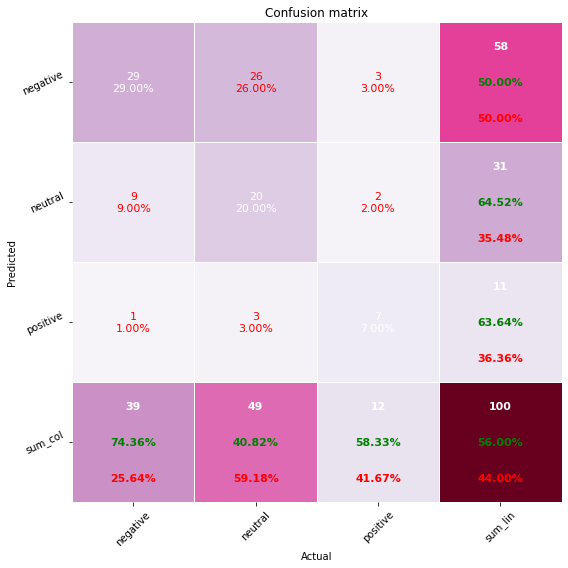

In [99]:
confusion = confusion_matrix(y_true, y_pred)
print(confusion)

array = np.array(confusion)
df_cm = pd.DataFrame(array, index=labels, columns=labels)
pp_matrix(df_cm, cmap='PuRd')

# 5. Emotion classifier 1

This pre-trained classifier can identify 6 emotions
- Sadness
- Joy
- Love
- Anger
- Fear
- Surprise

## Load and predict 

In [62]:
classifier = pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=False)
# https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion

In [63]:
labels_dict = {
    "sadness": 1, 
    "joy": 2,
    "love": 3,
    "anger": 4,
    "fear": 5, 
    "surprise": 6,
    "neutral": 7
}

In [85]:
df = pd.read_csv("./data/labelled/B.csv", index_col = 0)
df['label'] = df['text'].apply(lambda x: labels_dict[classifier(x)[0]['label']] if (classifier(x)[0]['score'] > 0.9) else 7)
df

,label,text
0,7,Ultimately WE Singaporeans are the one paying ...
1,1,Forgiveness is a personal choice. Often made a...
2,7,"She is very strong, very powerful, very aggres..."
3,2,How about you just worry about your own laundr...
4,7,Mke sure DONT USE TAXPAYER $$ TO PAY FOR THEIR...
...,...,...
95,2,just send him to our National Centre for Infec...
96,7,When China banned recycle waste to their count...
97,7,Overworked children during their childhood/ gr...
98,1,Forced to abandon their babies on doorsteps or...


In [86]:
y_pred = df['label'].tolist()

## Test accuracy

### Retrieve manual labels

In [66]:
label_df = pd.read_csv("./data/labelled/B.csv", index_col = 0)
y_true = label_df['label'].tolist()

label_df2 = pd.read_csv("./data/labelled/C.csv", index_col = 0)
y_true2 = label_df2['label'].tolist()

### Cohen's Kappa

In [67]:
cohen_kappa_score(y_true, y_true2)

0.44419408141805616

### Classification report and Confusion matrix

In [87]:
print(classification_report(y_true, y_pred, target_names = list(labels_dict.keys())))

              precision    recall  f1-score   support

     sadness       0.43      0.25      0.32        12
         joy       0.16      0.83      0.27         6
        love       0.00      0.00      0.00         1
       anger       0.62      0.24      0.35        41
        fear       0.00      0.00      0.00         3
    surprise       0.00      0.00      0.00         2
     neutral       0.36      0.46      0.41        35

    accuracy                           0.34       100
   macro avg       0.23      0.25      0.19       100
weighted avg       0.44      0.34      0.34       100



/home/joshua/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joshua/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joshua/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
confusion = confusion_matrix(y_true, y_pred)
print(confusion)

[[ 3  5  0  0  0  0  4]
 [ 0  5  0  0  0  0  1]
 [ 0  1  0  0  0  0  0]
 [ 3  9  0 12  3  0 14]
 [ 0  1  0  0  0  0  2]
 [ 1  0  0  0  0  0  1]
 [ 2 16  0  9  0  0  8]]


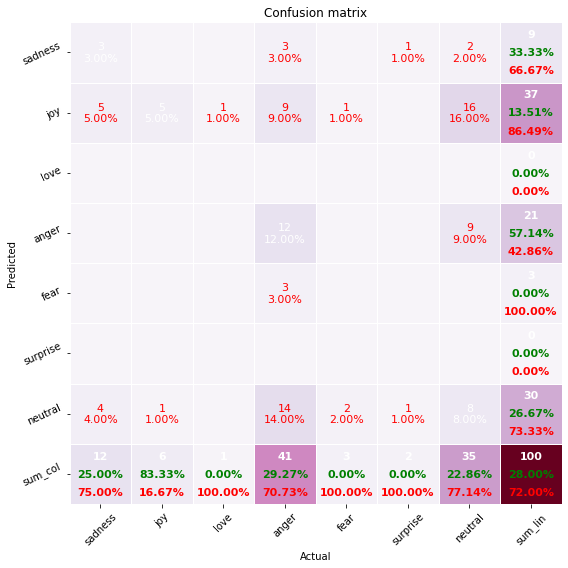

In [52]:
array = np.array(confusion)
labels = list(labels_dict.keys())
df_cm = pd.DataFrame(array, index=labels, columns=labels)
pp_matrix(df_cm, cmap='PuRd')

# 6. Emotion Classifier 2

## Load and predict (Facebook)

In [23]:
classifier2 = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

# https://huggingface.co/j-hartmann/emotion-english-distilroberta-base

In [24]:
labels_dict2 = {
    "anger": 1, 
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "neutral": 5, 
    "sadness": 6,
    "surprise": 7
}
labels2 = list(labels_dict2.keys())

In [30]:
df = pd.read_csv("./data/processed_data/facebook_test.csv", index_col = 0)
df['label'] = df['text'].apply(lambda x: labels_dict2[classifier2(x)[0]['label']] )
df

,text,label
0,Ultimately WE Singaporeans are the one paying ...,5
1,Forgiveness is a personal choice. Often made a...,6
2,"She is very strong, very powerful, very aggres...",3
3,How about you just worry about your own laundr...,3
4,Mke sure DONT USE TAXPAYER $$ TO PAY FOR THEIR...,1
...,...,...
95,just send him to our National Centre for Infec...,5
96,When China banned recycle waste to their count...,4
97,Overworked children during their childhood/ gr...,5
98,Forced to abandon their babies on doorsteps or...,6


In [29]:
y_pred = df['label'].tolist()

## Test accuracy

### Retrieve manual labels

In [30]:
label_df = pd.read_csv("./data/processed_data/facebook_labelled_sentiment2.csv", index_col = 0)
y_true = label_df['label'].tolist()

In [26]:
# test_text = "better him than CCS...in the end...this is what groupthink creates...you create a group of very privileged personnel who thinks they are the cream of the crop and they are born leaders...unfortunately they do not realise they are in a leader position simply because they follow orders..they do not lead. ironic."
# output = classifier2(test_text)
# output

### Classification report & confusion matrix

In [32]:
print(classification_report(y_true, y_pred, target_names = list(labels_dict.keys())))

              precision    recall  f1-score   support

       anger       0.55      0.58      0.56        19
     disgust       0.40      0.11      0.17        19
        fear       0.00      0.00      0.00         1
         joy       0.29      0.33      0.31         6
     neutral       0.62      0.57      0.60        49
     sadness       0.22      0.33      0.27         6
    surprise       0.00      0.00      0.00         0

    accuracy                           0.45       100
   macro avg       0.30      0.27      0.27       100
weighted avg       0.52      0.45      0.47       100



/home/joshua/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joshua/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joshua/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[11  1  2  0  5  0  0]
 [ 1  2  1  2  7  3  3]
 [ 0  0  0  0  1  0  0]
 [ 0  0  2  2  1  1  0]
 [ 8  2  3  3 28  3  2]
 [ 0  0  1  0  3  2  0]
 [ 0  0  0  0  0  0  0]]


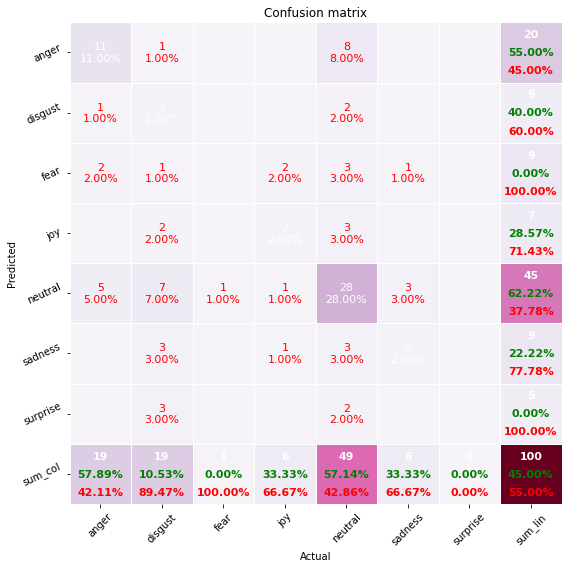

In [31]:
confusion = confusion_matrix(y_true, y_pred)
print(confusion)

array = np.array(confusion)
df_cm = pd.DataFrame(array, index=labels2, columns=labels2)
pp_matrix(df_cm, cmap='PuRd')

## Predict and test (Reddit)

In [31]:
df = pd.read_csv("./data/processed_data/reddit_test.csv", index_col = 0)
df['label'] = df['text'].apply(lambda x: labels_dict2[classifier2(x)[0]['label']] )
df

,text,label
0,MSM is really piss poor at reading the room - ...,2
1,"I always wonder why, very common, got stup**k ...",7
2,Just because there were young people who died ...,5
3,"Yeah, that's what people always say when I tel...",5
4,LOL. I don’t care. I just want someone patient...,5
...,...,...
95,This is literally how the donald trump subredd...,3
96,"sneezing from morn to night, trying to study b...",6
97,It didn't happen right after he made that comm...,5
98,Me. I have a stuffed funshine bear that's been...,2


In [32]:
label_df = pd.read_csv("./data/labelled/reddit_labelled.csv", index_col = 0)
y_true = label_df['label'].tolist()

In [34]:
print(classification_report(y_true, y_pred, target_names = list(labels_dict2.keys())))

              precision    recall  f1-score   support

       anger       0.33      0.29      0.31         7
     disgust       0.40      0.25      0.31         8
        fear       0.50      0.17      0.25        12
         joy       0.67      0.31      0.42        13
     neutral       0.55      0.82      0.66        39
     sadness       0.30      0.43      0.35         7
    surprise       0.27      0.21      0.24        14

    accuracy                           0.48       100
   macro avg       0.43      0.35      0.36       100
weighted avg       0.48      0.48      0.45       100



[[ 2  1  0  0  1  0  3]
 [ 2  2  0  0  3  0  1]
 [ 0  0  2  0  7  2  1]
 [ 0  0  1  4  5  1  2]
 [ 0  2  0  0 32  4  1]
 [ 0  0  0  1  3  3  0]
 [ 2  0  1  1  7  0  3]]


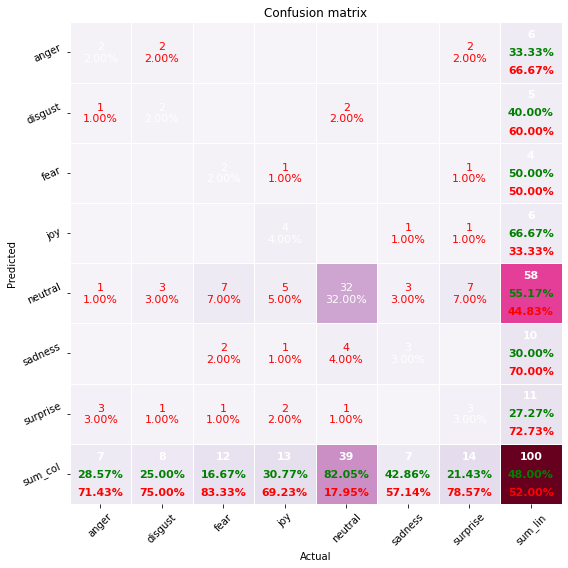

In [38]:
confusion = confusion_matrix(y_true, y_pred)
print(confusion)

array = np.array(confusion)
df_cm = pd.DataFrame(array, index=labels2, columns=labels2)
pp_matrix(df_cm, cmap='PuRd')

# Singlish

In [62]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('zanelim/singbert')
model = BertModel.from_pretrained("zanelim/singbert")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/219k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at zanelim/singbert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0618,  0.0530,  0.1623,  ...,  0.0686, -0.0867,  0.0329],
         [ 0.8930, -0.0657,  0.4486,  ...,  0.7556, -0.0042,  0.0745],
         [ 0.2020, -0.0953,  0.1591,  ..., -0.1678,  0.5205,  0.3917],
         ...,
         [ 0.5566,  0.3114,  0.5274,  ..., -0.7868, -0.3276,  0.0261],
         [-0.4843, -0.4276,  0.2344,  ...,  0.5812, -0.1522, -0.0432],
         [ 0.7202,  0.5534, -0.0298,  ...,  0.2427, -0.6086, -0.4270]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-5.2186e-01, -3.5544e-03,  9.5656e-01,  3.0579e-01, -6.5261e-01,
          5.5695e-04,  6.6412e-01, -6.9209e-02,  7.4266e-01, -8.8833e-01,
          4.2113e-01, -6.1861e-01,  9.2574e-01, -4.6609e-01,  7.4255e-01,
         -2.3167e-01, -1.7347e-03, -1.7984e-01,  8.5342e-02, -5.1691e-01,
          2.7140e-01, -9.6494e-01,  7.4370e-01, -2.8091e-02,  6.7800e-02,
         -7.9411e-01, -1.7708e-01,  8.3687e-01,  8.2854e-01,  3.651

# Zero-shot classification 1 (emotion)

In [2]:
def classify(text):
    results = classifier(
        text,
        candidate_labels=['anger', 'surprise', 'disgust', 'joy', 'fear', 'sadness', 'neutral']
    )
    return results["labels"][0]

In [96]:
labels_dict = {
    "anger": 1, 
    "surprise": 2,
    "disgust": 3,
    "joy": 4,
    "fear": 5, 
    "sadness": 6,
    "neutral": 7
}

In [14]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [108]:
df = pd.read_csv("./data/processed_data/twitter_test.csv", index_col = 0)
df

,text,text_processed
0,We’re addicted to the delicious assortment of ...,Were addicted to the delicious assortment of g...
1,@sellingmycode69 @plant_babes I know it involv...,I know it involves the killing of sentient b...
2,@fuckingleksua Thank u 😘,Thank u
3,Real 3D FlipBook WordPress Plugin v3.33 https...,Real 3D FlipBook WordPress Plugin v3.33
4,Siann the monday feels,Siann the monday feels
...,...,...
95,When even @PGodjira is bullish on @Zooversenft...,When even is bullish on . Probably nothing. ...
96,Golly gosh. it’s probably a good thing I’m mak...,Golly gosh. its probably a good thing Im makin...
97,VIOLATED https://t.co/WfjpXhZbIk,VIOLATED
98,@itsochibs Lol I might get those flowers after...,Lol I might get those flowers after all


In [99]:
df['labels'] = df['text_processed'].apply(lambda x: classify(x))
df

,text,text_processed,labels
0,We’re addicted to the delicious assortment of ...,Were addicted to the delicious assortment of g...,joy
1,@sellingmycode69 @plant_babes I know it involv...,I know it involves the killing of sentient b...,disgust
2,@fuckingleksua Thank u 😘,Thank u,joy
3,Real 3D FlipBook WordPress Plugin v3.33 https...,Real 3D FlipBook WordPress Plugin v3.33,surprise
4,Siann the monday feels,Siann the monday feels,surprise
...,...,...,...
95,When even @PGodjira is bullish on @Zooversenft...,When even is bullish on . Probably nothing. ...,surprise
96,Golly gosh. it’s probably a good thing I’m mak...,Golly gosh. its probably a good thing Im makin...,surprise
97,VIOLATED https://t.co/WfjpXhZbIk,VIOLATED,disgust
98,@itsochibs Lol I might get those flowers after...,Lol I might get those flowers after all,surprise


In [100]:
df['labels2'] = df['labels'].apply(lambda x: labels_dict[x])
df

,text,text_processed,labels,labels2
0,We’re addicted to the delicious assortment of ...,Were addicted to the delicious assortment of g...,joy,4
1,@sellingmycode69 @plant_babes I know it involv...,I know it involves the killing of sentient b...,disgust,3
2,@fuckingleksua Thank u 😘,Thank u,joy,4
3,Real 3D FlipBook WordPress Plugin v3.33 https...,Real 3D FlipBook WordPress Plugin v3.33,surprise,2
4,Siann the monday feels,Siann the monday feels,surprise,2
...,...,...,...,...
95,When even @PGodjira is bullish on @Zooversenft...,When even is bullish on . Probably nothing. ...,surprise,2
96,Golly gosh. it’s probably a good thing I’m mak...,Golly gosh. its probably a good thing Im makin...,surprise,2
97,VIOLATED https://t.co/WfjpXhZbIk,VIOLATED,disgust,3
98,@itsochibs Lol I might get those flowers after...,Lol I might get those flowers after all,surprise,2


In [102]:
y_pred = df['labels2'].tolist()

### Predict

In [105]:
df = pd.read_csv("./data/labelled/F.csv", index_col = 0)
y_true = df['annotations'].tolist()


In [107]:
print(classification_report(y_true, y_pred, target_names = list(labels_dict.keys())))

              precision    recall  f1-score   support

       anger       0.33      0.25      0.29         4
    surprise       0.31      0.73      0.43        26
     disgust       0.20      0.25      0.22         4
         joy       0.76      0.57      0.65        28
        fear       0.00      0.00      0.00         1
     sadness       0.50      0.11      0.18         9
     neutral       0.43      0.11      0.17        28

    accuracy                           0.41       100
   macro avg       0.36      0.29      0.28       100
weighted avg       0.48      0.41      0.38       100



/home/joshua/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joshua/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joshua/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Zero-shot Classification 2 (emotion)

### Load Model

In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [141]:
def classify(text):
    results = classifier(
        text,
        candidate_labels = ['anger', 'joy', 'fear', 'sadness'],
        # hypothesis_template = "{} is seen in this comment."
    )
    if results['scores'][0] < 0.85: # Classify as neutral if probability score is too low
        return "neutral"
    else:
        return results["labels"][0]

labels_dict = {
    "anger": 1, 
    "joy": 2,
    "fear": 3, 
    "sadness": 4,
    "neutral": 5
}

def classify2(text):
    results = classifier(
        text,
        candidate_labels = ['angry', 'joyful', 'fearful', 'sad'],
        hypothesis_template = "The person is feeling {}."
    )
    if results['scores'][0] < 0.5: # Classify as neutral if probability score is too low
        return "neutral"
    else:
        return results["labels"][0]

labels_dict2 = {
    "angry": 1, 
    "joyful": 2,
    "fearful": 3, 
    "sad": 4,
    "neutral": 5
}

In [94]:
text = "DBS has been profitable and this mirror the fact that the economy & importantly the local property sector strong showing for the last 15 years or so. Has DBS managed to expand regionally in Asean & Asia, for example, for the last 12 years or so? If yes. what are the figures?"
results = classifier(text, candidate_labels= ['anger', 'joy', 'fear', 'sadness'])
print(results)
print()

results2 = classifier(text, candidate_labels= ['angry', 'joyful', 'fearful', 'sad'], 
    hypothesis_template = "This comment is {}."
)
print(results2)
print()

results3 = classifier(
        text,
        candidate_labels = ['anger', 'joy', 'fear', 'sadness'],
        hypothesis_template = "This comment has {}."
    )
print(results3)

{'sequence': 'DBS has been profitable and this mirror the fact that the economy & importantly the local property sector strong showing for the last 15 years or so. Has DBS managed to expand regionally in Asean & Asia, for example, for the last 12 years or so? If yes. what are the figures?', 'labels': ['joy', 'anger', 'fear', 'sadness'], 'scores': [0.6695762872695923, 0.16524231433868408, 0.10945692658424377, 0.055724505335092545]}

{'sequence': 'DBS has been profitable and this mirror the fact that the economy & importantly the local property sector strong showing for the last 15 years or so. Has DBS managed to expand regionally in Asean & Asia, for example, for the last 12 years or so? If yes. what are the figures?', 'labels': ['joyful', 'angry', 'fearful', 'sad'], 'scores': [0.5993801355361938, 0.16425490379333496, 0.14395055174827576, 0.09241437911987305]}

{'sequence': 'DBS has been profitable and this mirror the fact that the economy & importantly the local property sector strong 

### Predict 1

In [108]:
df = pd.read_csv("./data/processed_data/twitter_test2.csv", index_col = 0)
df

,text,text_processed
0,ok good bruh for #shib,ok good bruh for
1,Make Your Trips To Your Favourite Clubs Much M...,Make Your Trips To Your Favourite Clubs Much M...
2,Todays fit is fire,Todays fit is fire
3,dope asf!!!,dope asf!!!
4,Dieing internally and externally,Dieing internally and externally
...,...,...
245,Science News https://t.co/ZqactvDHST,Science News
246,2/The average #crypto hodler #trades and waits...,2/The average hodler and waits and waits. h...
247,@hagiasofia_ Outstation?,Outstation?
248,[Notice-LTA] Accident on Nicoll Highway (towar...,Notice-LTA Accident on Nicoll Highway (towards...


In [142]:
df['labels'] = df['text_processed'].apply(lambda x: classify(x))
df

,annotations,text_processed,text,labels,labels2
0,2,ok good bruh for,ok good bruh for #shib,neutral,2
1,2,Make Your Trips To Your Favourite Clubs Much M...,Make Your Trips To Your Favourite Clubs Much M...,joy,2
2,2,Todays fit is fire,Todays fit is fire,anger,1
3,2,dope asf!!!,dope asf!!!,neutral,2
4,4,Dieing internally and externally,Dieing internally and externally,neutral,5
...,...,...,...,...,...
245,5,Science News,Science News https://t.co/ZqactvDHST,neutral,5
246,5,2/The average hodler and waits and waits. h...,2/The average #crypto hodler #trades and waits...,neutral,5
247,5,Outstation?,@hagiasofia_ Outstation?,neutral,5
248,5,Notice-LTA Accident on Nicoll Highway (towards...,[Notice-LTA] Accident on Nicoll Highway (towar...,neutral,5


In [143]:
df['labels2'] = df['labels'].apply(lambda x: labels_dict[x])
df

,annotations,text_processed,text,labels,labels2
0,2,ok good bruh for,ok good bruh for #shib,neutral,5
1,2,Make Your Trips To Your Favourite Clubs Much M...,Make Your Trips To Your Favourite Clubs Much M...,joy,2
2,2,Todays fit is fire,Todays fit is fire,anger,1
3,2,dope asf!!!,dope asf!!!,neutral,5
4,4,Dieing internally and externally,Dieing internally and externally,neutral,5
...,...,...,...,...,...
245,5,Science News,Science News https://t.co/ZqactvDHST,neutral,5
246,5,2/The average hodler and waits and waits. h...,2/The average #crypto hodler #trades and waits...,neutral,5
247,5,Outstation?,@hagiasofia_ Outstation?,neutral,5
248,5,Notice-LTA Accident on Nicoll Highway (towards...,[Notice-LTA] Accident on Nicoll Highway (towar...,neutral,5


In [144]:
y_pred = df['labels2'].tolist()

### Predict 2

In [121]:
df = pd.read_csv("./data/labelled/G.csv", index_col = 0)
df

,annotations,text_processed,text
0,2,ok good bruh for,ok good bruh for #shib
1,2,Make Your Trips To Your Favourite Clubs Much M...,Make Your Trips To Your Favourite Clubs Much M...
2,2,Todays fit is fire,Todays fit is fire
3,2,dope asf!!!,dope asf!!!
4,4,Dieing internally and externally,Dieing internally and externally
...,...,...,...
245,5,Science News,Science News https://t.co/ZqactvDHST
246,5,2/The average hodler and waits and waits. h...,2/The average #crypto hodler #trades and waits...
247,5,Outstation?,@hagiasofia_ Outstation?
248,5,Notice-LTA Accident on Nicoll Highway (towards...,[Notice-LTA] Accident on Nicoll Highway (towar...


In [127]:
df['labels'] = df['text_processed'].apply(lambda x: classify2(x))
df

,annotations,text_processed,text,labels,labels2
0,2,ok good bruh for,ok good bruh for #shib,joyful,2
1,2,Make Your Trips To Your Favourite Clubs Much M...,Make Your Trips To Your Favourite Clubs Much M...,joyful,2
2,2,Todays fit is fire,Todays fit is fire,angry,1
3,2,dope asf!!!,dope asf!!!,joyful,2
4,4,Dieing internally and externally,Dieing internally and externally,fearful,5
...,...,...,...,...,...
245,5,Science News,Science News https://t.co/ZqactvDHST,neutral,5
246,5,2/The average hodler and waits and waits. h...,2/The average #crypto hodler #trades and waits...,fearful,5
247,5,Outstation?,@hagiasofia_ Outstation?,neutral,5
248,5,Notice-LTA Accident on Nicoll Highway (towards...,[Notice-LTA] Accident on Nicoll Highway (towar...,fearful,3


In [128]:
df['labels2'] = df['labels'].apply(lambda x: labels_dict2[x])
df

,annotations,text_processed,text,labels,labels2
0,2,ok good bruh for,ok good bruh for #shib,joyful,2
1,2,Make Your Trips To Your Favourite Clubs Much M...,Make Your Trips To Your Favourite Clubs Much M...,joyful,2
2,2,Todays fit is fire,Todays fit is fire,angry,1
3,2,dope asf!!!,dope asf!!!,joyful,2
4,4,Dieing internally and externally,Dieing internally and externally,fearful,3
...,...,...,...,...,...
245,5,Science News,Science News https://t.co/ZqactvDHST,neutral,5
246,5,2/The average hodler and waits and waits. h...,2/The average #crypto hodler #trades and waits...,fearful,3
247,5,Outstation?,@hagiasofia_ Outstation?,neutral,5
248,5,Notice-LTA Accident on Nicoll Highway (towards...,[Notice-LTA] Accident on Nicoll Highway (towar...,fearful,3


In [129]:
y_pred2 = df['labels2'].tolist()

### Test

In [104]:
df = pd.read_csv("./data/labelled/G.csv", index_col = 0)
y_true = df['annotations'].tolist()

In [145]:
print(classification_report(y_true, y_pred, target_names = list(labels_dict.keys())))

              precision    recall  f1-score   support

       anger       0.50      0.12      0.20         8
         joy       0.90      0.32      0.47        87
        fear       1.00      0.11      0.20         9
     sadness       1.00      0.29      0.44        21
     neutral       0.58      0.98      0.73       125

    accuracy                           0.63       250
   macro avg       0.80      0.36      0.41       250
weighted avg       0.74      0.63      0.58       250



In [130]:
print(classification_report(y_true, y_pred2, target_names = list(labels_dict2.keys())))

              precision    recall  f1-score   support

       angry       0.30      0.38      0.33         8
      joyful       0.82      0.61      0.70        87
     fearful       0.16      0.67      0.26         9
         sad       0.75      0.43      0.55        21
     neutral       0.67      0.68      0.68       125

    accuracy                           0.62       250
   macro avg       0.54      0.55      0.50       250
weighted avg       0.70      0.62      0.65       250



# Zero-shot Classification 3 (3-class sentiment)

### Predict

In [22]:
def classify(text):
    results = classifier(
        text,
        candidate_labels = ['negative', 'positive']
    )
    if results['scores'][0] < 0.7: # Classify as neutral if probability score is too low
        return "neutral"
    else:
        return results["labels"][0]

labels_dict = {
    "negative": 1,
    "neutral": 2,
    "positive": 3
}

In [23]:
df = pd.read_csv("./data/labelled/H.csv", index_col = 0)
df

,annotations,text
0,1,This is scary. Actually at Little India mrt st...
1,2,"When a government is legally elected, they wil..."
2,1,Discretionary turn again. All heavy traffic ju...
3,2,I know of quite a few very rich millionaire bu...
4,1,Agenda 21 population control from US and EU wi...
...,...,...
145,1,"Lol... Last year this time, Creative shared cl..."
146,1,When public complaint n make viral the ministr...
147,3,Lucky for the boys. Phone were working well. G...
148,1,Saying this. And then you allow infected vac...


In [24]:
df['labels'] = df['text'].apply(lambda x: classify(x))
df

,annotations,text,labels
0,1,This is scary. Actually at Little India mrt st...,negative
1,2,"When a government is legally elected, they wil...",neutral
2,1,Discretionary turn again. All heavy traffic ju...,negative
3,2,I know of quite a few very rich millionaire bu...,neutral
4,1,Agenda 21 population control from US and EU wi...,negative
...,...,...,...
145,1,"Lol... Last year this time, Creative shared cl...",negative
146,1,When public complaint n make viral the ministr...,negative
147,3,Lucky for the boys. Phone were working well. G...,positive
148,1,Saying this. And then you allow infected vac...,negative


In [25]:
df['labels2'] = df['labels'].apply(lambda x: labels_dict[x])
df

,annotations,text,labels,labels2
0,1,This is scary. Actually at Little India mrt st...,negative,1
1,2,"When a government is legally elected, they wil...",neutral,2
2,1,Discretionary turn again. All heavy traffic ju...,negative,1
3,2,I know of quite a few very rich millionaire bu...,neutral,2
4,1,Agenda 21 population control from US and EU wi...,negative,1
...,...,...,...,...
145,1,"Lol... Last year this time, Creative shared cl...",negative,1
146,1,When public complaint n make viral the ministr...,negative,1
147,3,Lucky for the boys. Phone were working well. G...,positive,3
148,1,Saying this. And then you allow infected vac...,negative,1


In [26]:
y_pred = df['labels2'].tolist()

### Test

In [27]:
y_true = df['annotations'].tolist()

In [28]:
print(classification_report(y_true, y_pred, target_names = list(labels_dict.keys())))

              precision    recall  f1-score   support

    negative       0.73      0.95      0.82        84
     neutral       0.76      0.29      0.42        45
    positive       0.70      0.76      0.73        21

    accuracy                           0.73       150
   macro avg       0.73      0.67      0.66       150
weighted avg       0.73      0.73      0.69       150



# Testing how long it takes to classify a file

In [28]:
############### EMOTIONS ###############
def classify_emotions(text: str) -> str:
    """
    Takes in an input text and returns the emotions label.

    Args:
        text (str): Text to be classified.

    Returns:
        str: Label of the given input text.
    """
    classifier = pipeline("zero-shot-classification")
    results = classifier(text, candidate_labels=["anger", "joy", "fear", "sadness"])

    # Classify as neutral if probability score is too low
    return "neutral" if results["scores"][0] < 0.75 else results["labels"][0]


############### SENTIMENT ###############
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
# tokenizer.save_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
labels = ["negative", "neutral", "positive"]


def classify_sentiment(text: str) -> str:
    encoded_input = tokenizer(text, return_tensors="pt")
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    return labels[ranking[0]]

In [134]:
FACEBOOK_HISTORICAL_DATA_PATH = "./data/facebook_raw"
FACEBOOK_HISTORICAL_OUTPUT_DATA_PATH = "./data/facebook_processed"

for file in os.listdir(FACEBOOK_HISTORICAL_DATA_PATH):
    file_name = file[:-4]

    # Read data files
    df = pd.read_csv(f"{FACEBOOK_HISTORICAL_DATA_PATH}/{file}", header=0, sep=";", low_memory=False)

    # Drop rows with error or missing data
    df.drop(df[df["query_status"] == "error (400)"].index, inplace=True)
    df.drop(df[df["object_type"] != "data"].index, inplace=True)
    df.dropna(subset=["created_time", "message"], inplace=True)
    

    # Set relevant columns
    facebook_fields = [
        "id",
        "query_type",
        "parent_id",
        "object_id",
        "message",
        "created_time",
        "comments.summary.total_count",
        "reactions.summary.total_count",
        "like.summary.total_count",
        "love.summary.total_count",
        "haha.summary.total_count",
        "wow.summary.total_count",
        "sad.summary.total_count",
        "angry.summary.total_count",
    ]

    # Filtered data with relevant columns
    df_new = df[facebook_fields]

    # Rename columns
    df_new.rename(
        columns={
            "query_type": "is_post",
            "comments.summary.total_count": "comments_cnt",
            "reactions.summary.total_count": "reactions_cnt",
            "like.summary.total_count": "likes_cnt",
            "love.summary.total_count": "loves_cnt",
            "haha.summary.total_count": "haha_cnt",
            "wow.summary.total_count": "wow_cnt",
            "sad.summary.total_count": "sad_cnt",
            "angry.summary.total_count": "angry_cnt",
        },
        inplace=True,
    )

    # Label encoding
    df_new["is_post"].replace({"Facebook:/<page-id>/posts": 1, "Facebook:/<post-id>/comments": 0}, inplace=True)

    # Add fb_group column
    df_new["fb_group"] = file_name

    # Filter df to df_posts and df_comments
    df_posts = df_new[df_new["is_post"] == 1]
    df_posts.reset_index(inplace=True, drop=True)
    df_comments = df_new[df_new["is_post"] == 0]
    df_comments.reset_index(inplace=True, drop=True)

    # Run classification on df_posts and df_comments
    df_comments = classify_sentiment(df_comments)
    df_posts = classify_sentiment(df_posts)
    
    # df_posts["sentiment_label"] = df_posts["message"].apply(lambda x: classify_sentiment(x))
    # df_posts["emotions_label"] = df_posts["message"].apply(lambda x: classify_emotions(x))
    # df_comments["sentiment_label"] = df_comments["message"].apply(lambda x: classify_sentiment(x))
    # df_comments["emotions_label"] = df_comments["message"].apply(lambda x: classify_emotions(x))

    # Save processed data to json file, with each row as a json record
    df_posts.to_json(f"{FACEBOOK_HISTORICAL_OUTPUT_DATA_PATH}/{file_name}_posts.json", orient="index")
    df_comments.to_json(f"{FACEBOOK_HISTORICAL_OUTPUT_DATA_PATH}/{file_name}_comments.json", orient="index")
    
    print(f"{file_name} done")
    break


/tmp/ipykernel_675938/3892535732.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["fb_group"] = file_name


  0%|          | 0/271691 [00:00<?, ?it/s]

# Saving models offline

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

In [2]:
tokenizer.save_pretrained("../models/model_data/bart-large-mnli")
model.save_pretrained("../models/model_data/bart-large-mnli")

In [6]:
tokenizer = AutoTokenizer.from_pretrained("../models/model_data/bart-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("../models/model_data/bart-large-mnli")

Some weights of the model checkpoint at ../models/model_data/bart-large-mnli were not used when initializing BartForSequenceClassification: ['lm_head.weight', 'final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at ../models/model_data/bart-large-mnli and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.out_proj.weight', 'classification_head.dense.bias', 'classification_head.dense.weight']
You should probably 